# Training Your Custom Magic Wand Model

It is now time for you to train your own custom magic wand model using your Custom Dataset!

##Setup

### Import Packages and Set Constants

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from google.colab import files
from IPython.display import Image, display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import PIL
import math
import glob
import json
import os
!apt-get update && apt-get -qq install xxd

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:5 https://cli.github.com/packages stable InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu 

In [ ]:
#DO NOT MODIFY THIS CELL
# Define filenames and set up directory structure
MODELS_DIR = 'models'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)
SAVED_MODEL_FILENAME = os.path.join(MODELS_DIR, "magic_wand")
FLOAT_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, "magic_wand_float.tfl")
QUANTIZED_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, "magic_wand.tfl")
TFL_CC_MODEL_FILENAME = os.path.join(MODELS_DIR, "magic_wand.cc")

DATASET_DIR =  'dataset'
if not os.path.exists(DATASET_DIR):
  os.mkdir(DATASET_DIR)
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "validation")
TEST_DIR = os.path.join(DATASET_DIR, "test")
!rm -rf sample_data

CHKPT_DIR =  'checkpoints'
if not os.path.exists(CHKPT_DIR):
  os.mkdir(CHKPT_DIR)

## 1.2 Decide a train test split for your dataset
### TASK: 1.2.1 Train test split
This is am important step. Choose wisely what should be the split for your dataset.

In [ ]:
# TODO - Choose a Train, validation, test Split Pecentage for your dataset
TEST_PERCENTAGE = 70
VALIDATION_PERCENTAGE = 15
TRAIN_PERCENTAGE = 15

### Task: 1.2.2 Load Your Custom Dataset
Now you'll need to upload all of your custom gesture files that you created using the Magic Wand tool (aka the ```*.json``` files). **Note: you can select multiple files and upload them all at once!**

If you are having trouble uploading files because your internet bandwidth is too slow feel free to uncomment the lines below to instead use Pete's digits dataset.

In [ ]:
import os

DATASET_DIR = "/content/dataset"
os.makedirs(DATASET_DIR, exist_ok=True)

print("Upload your wanddata JSON files...")

# --- Upload button (files go directly into /content/dataset) ---
from google.colab import files

uploaded = files.upload()

# Move uploaded files to /content/dataset
for fname in uploaded.keys():
    src = fname
    dst = os.path.join(DATASET_DIR, fname)
    os.rename(src, dst)
    print(f"Saved: {dst}")

print("\nAll uploaded files are now located in /content/dataset")


Upload your wanddata JSON files...


Saving wanddata_0.json to wanddata_0.json
Saving wanddata_1.json to wanddata_1.json
Saved: /content/dataset/wanddata_0.json
Saved: /content/dataset/wanddata_1.json

All uploaded files are now located in /content/dataset


In [ ]:
# Or use Pete's Digits Dataset
# !curl -L https://github.com/petewarden/magic_wand_digit_data/archive/8170591863f9addca27b1a963263f7c7bed33f41.zip -o magic_wand_digit_data.zip
# !unzip magic_wand_digit_data.zip
# !rm -rf magic_wand_digit_data.zip
# !mv magic_wand_digit_data-*/* dataset
# !rm -rf magic_wand_digit_data-*

###  TASK: 1.2.3 Number of gestures
**Update the variable below with the number of labeled gestures in your dataset**
Note: Use the number of unique gestures/labels and *not* the number of samples in your dataset.

In [ ]:
NUM_GESTURES =  2

Next we'll parse the JSON files into a python object which we can more easily work with.

In [ ]:
#DO NOT MODIFY THIS CELL
dataset_jsons = DATASET_DIR + "/*.json"
strokes = []
for filename in glob.glob(dataset_jsons):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    strokes.append(stroke)

In [ ]:
# See what labels are present before filtering
print("Labels before filtering:", sorted(set(s["label"] for s in strokes)))

# Keep only the gestures you collected custom dataset for
allowed_labels = {"0","1","2","3","4","5","6","7","8","9"}
strokes = [s for s in strokes if s["label"] in allowed_labels]

# Sanity check
print("Labels after filtering:", sorted(set(s["label"] for s in strokes)))
print("Total strokes after filtering:", len(strokes))
print(strokes)

Labels before filtering: ['0', '1']
Labels after filtering: ['0', '1']
Total strokes after filtering: 80
[{'index': 0, 'strokePoints': [{'x': -0.003742578426996867, 'y': 0.002262510673867332}, {'x': -0.004709499507314629, 'y': 0.005975402941306432}, {'x': -0.005932993975778421, 'y': 0.0020165393253167483}, {'x': -0.012718405280676155, 'y': -0.014459287308984332}, {'x': -0.015012722532782291, 'y': -0.033070398420095445}, {'x': -0.012141645339628061, 'y': -0.04162637793355518}, {'x': -0.012881679257584943, 'y': -0.04059796396642923}, {'x': -0.03377226510395606, 'y': -0.036749363578855984}, {'x': -0.06449321480674876, 'y': -0.05452290028747585}, {'x': -0.08168363040106165, 'y': -0.10791136659267876}, {'x': -0.09098388471951087, 'y': -0.1684966089700659}, {'x': -0.08815945730855068, 'y': -0.2202374905720353}, {'x': -0.06113231552557813, 'y': -0.25328456478400363}, {'x': -0.026891433923608727, 'y': -0.2731764218252566}, {'x': 0.00599660714881288, 'y': -0.2743320622346881}, {'x': 0.033852841

## 1.3 Visualize Data
It is very important to visualize the data before proceeding to design your model.
### TASK: 1.3.1 Let's visualize the data
**Write the code** for the below visualize function.
You can take help from previous tutorials and assignments.

In [ ]:
# Helper function to visualize the data
def plot_stroke(stroke):
  x_array = []
  y_array = []

  #ENTER CODE BELOW
  points = stroke["strokePoints"]
  xs = [p["x"] for p in points]
  ys = [p["y"] for p in points]
  plt.plot(xs, ys)

  plt.show()

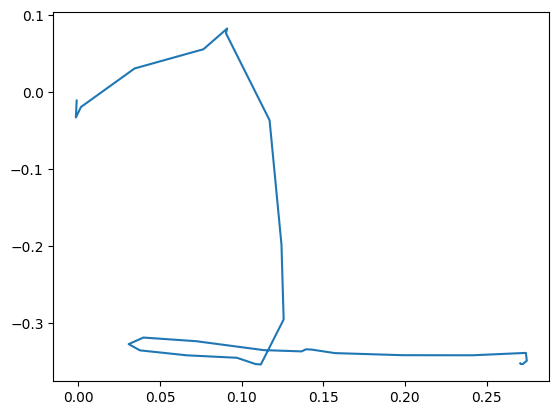

In [ ]:
# Display a stroke from the strokes python variable
plot_stroke(strokes[41])

### TASK: 1.3.2 Save the image
**Download the image generated by the dataset and put it with the section number in your assignment document.**

###1.4 Preprocess your Dataset
Next we'll preprocess the dataset to prepare it for training. By preprocessing the data in bulk before training the whole training process will execute much faster. To do so, we'll convert the strokes into rastered images using the helper functions below. This is the process used in real-time in the Arduino code to convert a gesture into an image that the CNN we are going to train can then process.

Once we have converted the dataset to rasterized images we will generate a ```Keras``` dataset for use in training.

In [ ]:
#DO NOT MODIFY THIS CELL
FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue

  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

In [ ]:
X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
    label_path = Path(root_folder, label)
    ensure_empty_dir(label_path)

  label_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))
    for i in range(augment_count):
      augmented_points = augment_points(points, 0.1, 0.1, 0.3)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))
  return labels

Take the dataset and shuffle it into the Training/Validation/Test splits

In [ ]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

shuffled_strokes = strokes
np.random.shuffle(shuffled_strokes)

test_count = math.floor((len(shuffled_strokes) * TEST_PERCENTAGE) / 100)
validation_count = math.floor((len(shuffled_strokes) * VALIDATION_PERCENTAGE) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

print(test_count)
print(validation_count)

labels_test  = save_strokes_as_images(test_strokes, TEST_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, 10)
labels_val   = save_strokes_as_images(validation_strokes, VAL_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, 0)
labels_train = save_strokes_as_images(train_strokes, TRAIN_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, 10)

56
12


### TASK: 1.4.1  Order of the classes
Also get the alphanumeric ordering of the labels as the Nueral Network will output its result in this order for the predicted class. **Make a note of this ordering as you will need to enter the labels in order in the Arduino code!**

In [ ]:
labels = sorted(labels_test.union(labels_val).union(labels_train))
# get the conversion from label string to int
labelToInt = {}
currInt = 0
for label in labels:
  labelToInt[label] = currInt
  currInt = currInt + 1
intToLabel = {v: k for k, v in labelToInt.items()}
print(intToLabel)

{0: '0', 1: '1'}


If you'd like to visualize the difference between a stroke and its rasterized output image, run the cell below!

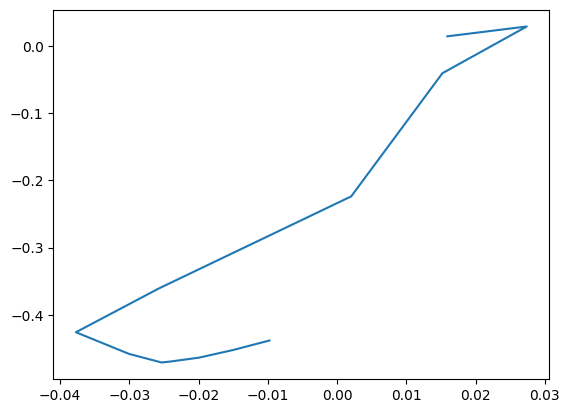

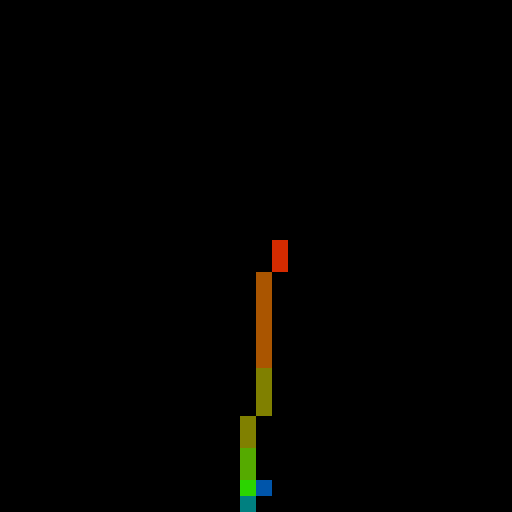

In [ ]:
plot_stroke(strokes[0])
raster = rasterize_stroke(strokes[0]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

Finally, we'll generate a dataset in ```Keras```.

In [ ]:
validation_ds = image_dataset_from_directory(
    directory=VAL_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds = image_dataset_from_directory(
    directory=TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)


Found 12 files belonging to 2 classes.
Found 132 files belonging to 2 classes.


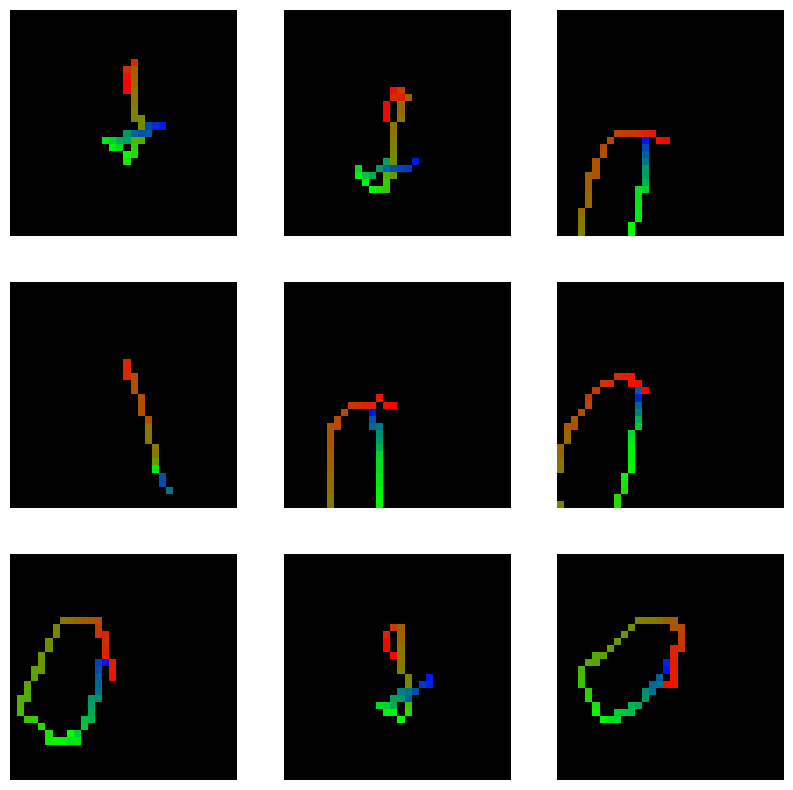

In [ ]:
# Plot 9 of our final dataset items
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

## 1.5 Define your Model

Next we will define and visualize the CNN model that we will use for the magic wand!

### Task: 1.5.1 Model definition
Following are some of the layers that you can use Conv2D, BatchNormalization, Dropouts, GlobalAveragePooling2D etc.
We have added an output dense layer.
Don't forget to add activation functions and some dense layers.

*** Hint: Try to have atleast 3 CNN layers for extracting features  ***

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # ENTER CODE BELOW
    x = layers.Rescaling(1.0 / 255)(inputs)

    x = layers.Conv2D(32, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)
    # The second convolution
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(2,2)(x)
    # The third convolution
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.GlobalAveragePooling2D()(x)





    #ENTER CODE ABOVE
    outputs = layers.Dense(2, activation='sigmoid')(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=NUM_GESTURES)

###Task: 1.5.2 Visualize Model
Paste your model into the final document.

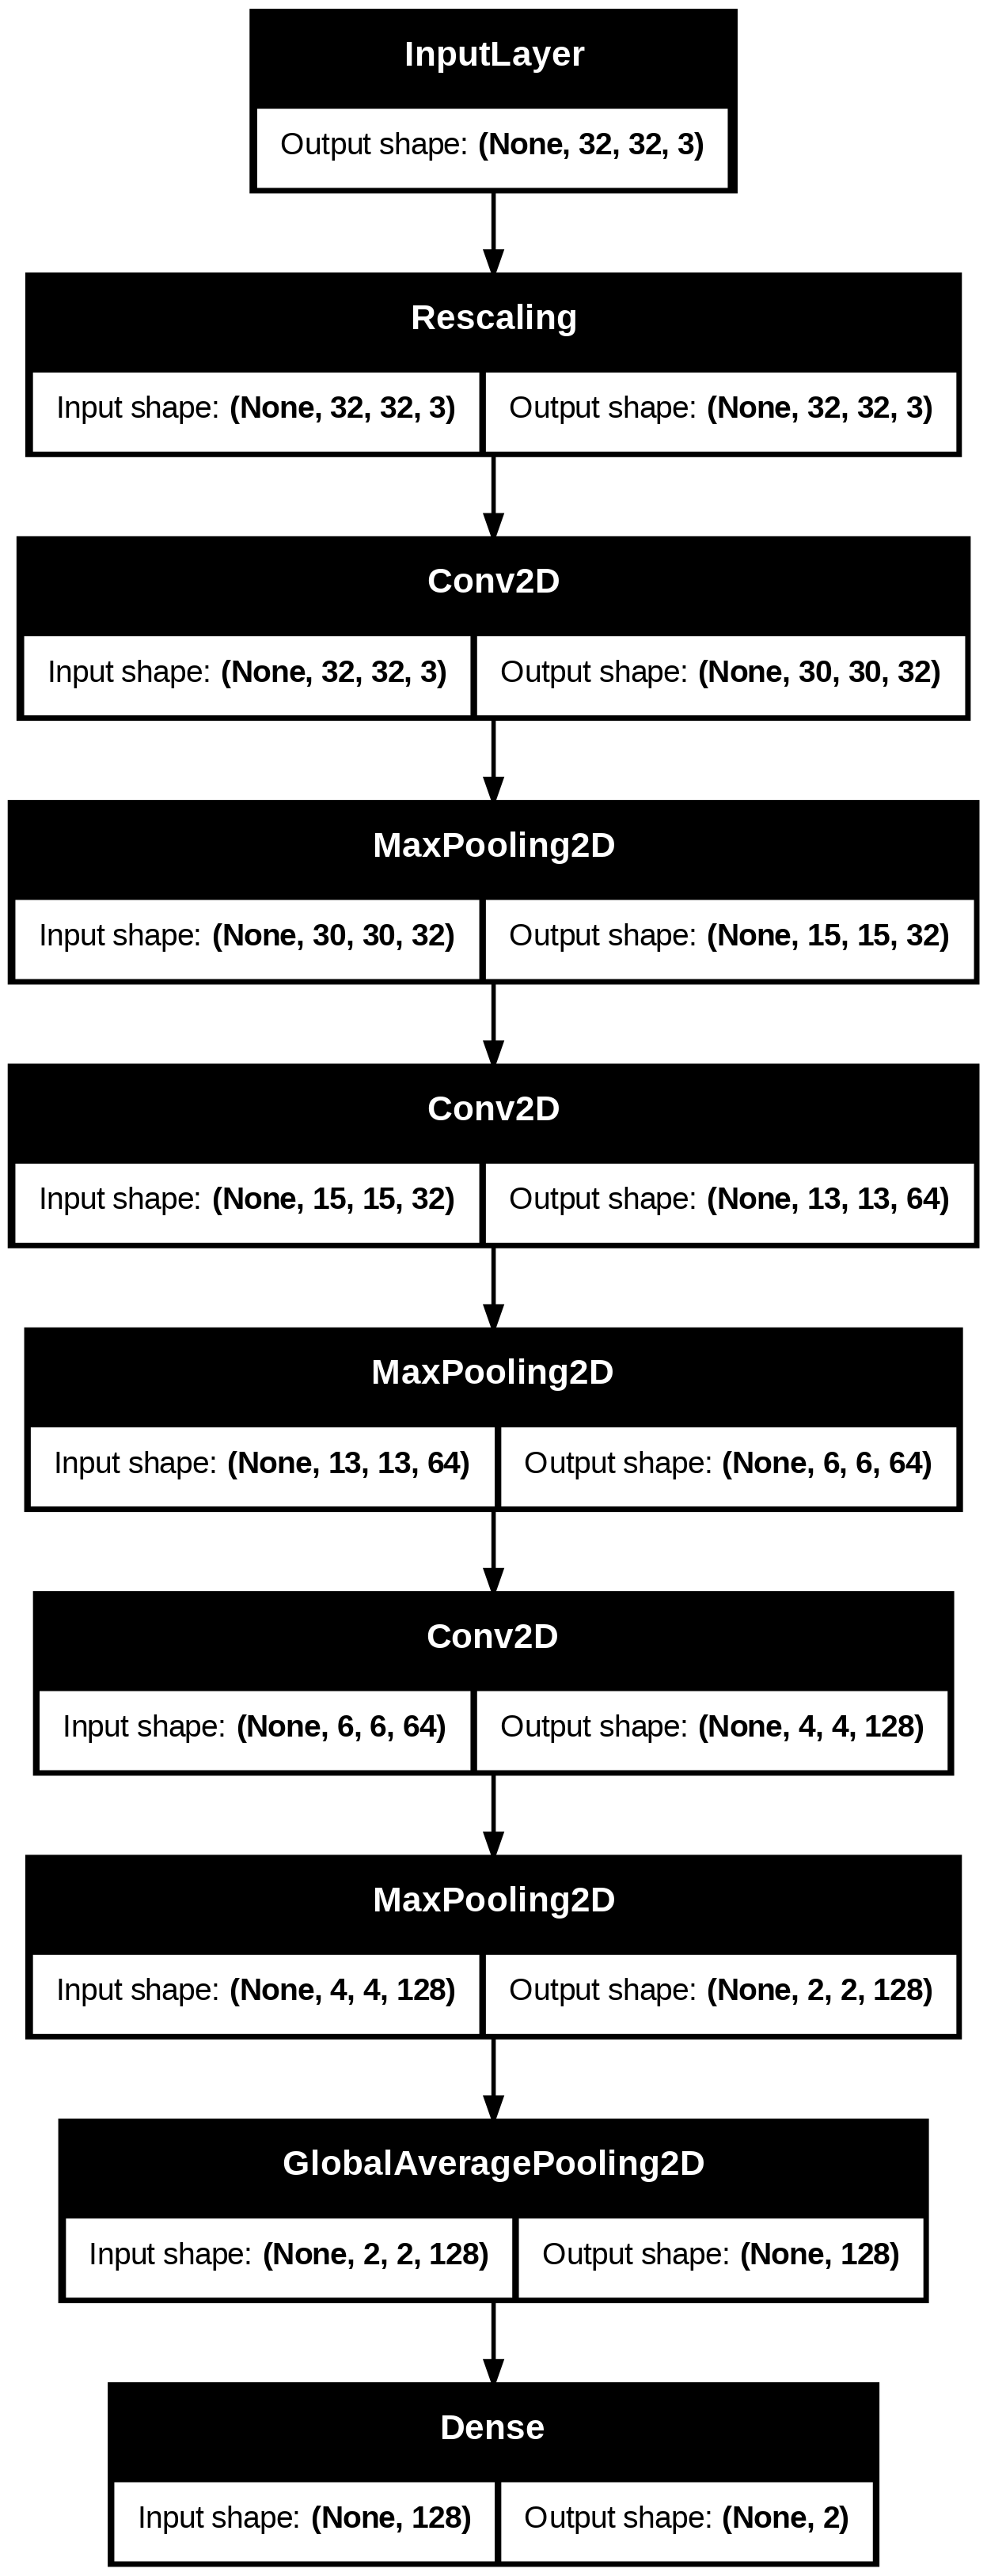

In [ ]:
# View the model layers as a diagram
keras.utils.plot_model(model, show_shapes=True)

##1.6 Train your Model

Now that we have a preprocessed dataset and a model its time to train that model with that dataset!

###Task: 1.6.1 Compile and Train the model


Here you have to compile and train the model that you have defined earlier. You will also have to choose the number of epochs for this.

In [ ]:
import os, numpy as np
from pathlib import Path
from PIL import Image
import tensorflow as tf

TRAIN_DIR = "/content/dataset/train"   # <-- your train folder
VAL_DIR   = "/content/dataset/validation"     # <-- your val folder
# ===================================

# Defaults if not already defined above
IMAGE_HEIGHT = globals().get("IMAGE_HEIGHT", 224)
IMAGE_WIDTH  = globals().get("IMAGE_WIDTH", 224)
BATCH_SIZE   = globals().get("BATCH_SIZE", 32)

assert Path(TRAIN_DIR).exists(), f"TRAIN_DIR not found: {TRAIN_DIR}"
assert Path(VAL_DIR).exists(),   f"VAL_DIR not found: {VAL_DIR}"

# 1) Canonical class list from TRAIN
train_classes = sorted([p.name for p in Path(TRAIN_DIR).iterdir() if p.is_dir()])
assert len(train_classes) > 0, f"No class folders found in {TRAIN_DIR}"
print("TRAIN classes:", train_classes, " (", len(train_classes), ")")

# 2) Ensure every TRAIN class exists in VAL; if missing, create a placeholder image
val_classes = sorted([p.name for p in Path(VAL_DIR).iterdir() if p.is_dir()])
missing = [c for c in train_classes if c not in val_classes]
if missing:
    print("VAL missing classes:", missing, " -> creating 1 placeholder per missing class")
    for c in missing:
        os.makedirs(Path(VAL_DIR)/c, exist_ok=True)
        img = Image.fromarray(np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.uint8))  # black image
        img.save(Path(VAL_DIR)/c/"_placeholder.jpg")

# 3) Rebuild datasets with a SHARED, FIXED class_names (prevents 15 vs 14 mismatches)
tf.keras.backend.clear_session()

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    label_mode="categorical",      # one-hot labels
    class_names=train_classes,     # <-- shared mapping
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=123,
    label_mode="categorical",
    class_names=train_classes,     # <-- shared mapping
)

# Verify depths match
nc_train = train_ds.element_spec[1].shape[-1]
nc_val   = validation_ds.element_spec[1].shape[-1]
assert nc_train == len(train_classes) == nc_val, f"Depth mismatch: train={nc_train} val={nc_val}"
print("Datasets aligned. num_classes =", len(train_classes))


TRAIN classes: ['0', '1']  ( 2 )
Found 132 files belonging to 2 classes.
Found 12 files belonging to 2 classes.
Datasets aligned. num_classes = 2


In [ ]:
# --- Make validation classes match training classes (auto-fix) ---

from pathlib import Path
import os, numpy as np
from PIL import Image
import tensorflow as tf

# Set your dirs (change only if different)
TRAIN_DIR = "/content/dataset/train"
VAL_DIR   = "/content/dataset/validation"

# 1) Canonical class list from TRAIN
train_classes = sorted([p.name for p in Path(TRAIN_DIR).iterdir() if p.is_dir()])
print("TRAIN classes:", train_classes, " (", len(train_classes), ")")

# 2) Ensure every TRAIN class exists in VAL; if missing, create a placeholder image
val_classes = sorted([p.name for p in Path(VAL_DIR).iterdir() if p.is_dir()])
missing = [c for c in train_classes if c not in val_classes]
if missing:
    print("VAL missing classes:", missing, " -> creating placeholders")
    for c in missing:
        os.makedirs(Path(VAL_DIR)/c, exist_ok=True)
        # write a black placeholder image with correct size
        img = Image.fromarray(np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.uint8))
        img.save(Path(VAL_DIR)/c/"placeholder.jpg")

# 3) Rebuild datasets with a SHARED, FIXED class_names (prevents 14 vs 15 mismatches)
BATCH_SIZE = BATCH_SIZE  # keep whatever you already set
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    label_mode="categorical",      # one-hot labels
    class_names=train_classes,     # <-- shared mapping
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=123,
    label_mode="categorical",
    class_names=train_classes,     # <-- shared mapping
)

# Optional: verify depths match
assert train_ds.element_spec[1].shape[-1] == len(train_classes)
assert validation_ds.element_spec[1].shape[-1] == len(train_classes)
print("Datasets aligned. num_classes =", len(train_classes))


TRAIN classes: ['0', '1']  ( 2 )
Found 132 files belonging to 2 classes.
Found 12 files belonging to 2 classes.
Datasets aligned. num_classes = 2


In [ ]:
# How many epochs to train for; ~30 is a good starting point
EPOCHS = 30

# Callback to save model checkpoints for future inspection or training
checkpointFileLoc = CHKPT_DIR + "/save_at_{epoch:02d}.keras"
modelCheckpointCallback = keras.callbacks.ModelCheckpoint(checkpointFileLoc)

# Derive number of classes from the TRAIN dataset's one-hot label depth
NUM_CLASSES = train_ds.element_spec[1].shape[-1]
assert NUM_CLASSES is not None, "Could not infer NUM_CLASSES from train_ds labels."

# (Re)build the model with the correct number of classes
model = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=NUM_CLASSES)

# Compile with categorical loss for one-hot labels
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Optional safety check: ensure val labels have the same depth
val_classes = validation_ds.element_spec[1].shape[-1]
assert val_classes == NUM_CLASSES, f"Train/Val class mismatch: {NUM_CLASSES} vs {val_classes}"

# Train
history = model.fit(
      train_ds,
      validation_data=validation_ds,
      epochs=EPOCHS,
      callbacks=[modelCheckpointCallback]
)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 613ms/step - accuracy: 0.5241 - loss: 0.6696 - val_accuracy: 0.5833 - val_loss: 0.4995
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6884 - loss: 0.5545 - val_accuracy: 1.0000 - val_loss: 0.3419
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8612 - loss: 0.4268 - val_accuracy: 1.0000 - val_loss: 0.1888
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8802 - loss: 0.3007 - val_accuracy: 1.0000 - val_loss: 0.0896
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8533 - loss: 0.2755 - val_accuracy: 1.0000 - val_loss: 0.0743
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9110 - loss: 0.1793 - val_accuracy: 1.0000 - val_loss: 0.0709
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9566 - loss: 0.1849 - val_accuracy: 1.0000 - val_loss: 0.1413
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9329 - loss: 0.1401 - val_accuracy: 1.0000 - val_loss: 0.0557

In [ ]:
import os
os.makedirs("models", exist_ok=True)


In [ ]:
# Save in the modern Keras format
model.save("models/magic_wand.keras")

# Also export a SavedModel directory (useful for TF ops tooling)
model.export("models/magic_wand_saved_model")


Saved artifact at 'models/magic_wand_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134275167829648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134275167822352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134275167825040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134275167821008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134275167821200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134275168501584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134275168500240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134275167820240: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
SAVED_MODEL_FILENAME = "models/magic_wand"

In [ ]:
tf.__version__

'2.19.0'

In [ ]:
keras.__version__

'3.10.0'

In [ ]:
import os, glob, pathlib, sys
print("CWD:", os.getcwd())
print("Exists(models):", os.path.isdir("models"))
print("Files under models/:")
for p in glob.glob("models/**", recursive=True):
    print("  ", p)


CWD: /content
Exists(models): True
Files under models/:
   models/
   models/magic_wand_saved_model
   models/magic_wand_saved_model/saved_model.pb
   models/magic_wand_saved_model/variables
   models/magic_wand_saved_model/variables/variables.data-00000-of-00001
   models/magic_wand_saved_model/variables/variables.index
   models/magic_wand_saved_model/fingerprint.pb
   models/magic_wand_saved_model/assets
   models/magic_wand.keras


In [ ]:
import os
import tensorflow as tf

#point to our SavedModel directory (must contain saved_model.pb) ---
SAVED_MODEL_DIR = "models/magic_wand_saved_model"
assert os.path.exists(os.path.join(SAVED_MODEL_DIR, "saved_model.pb")), \
    f"Not a SavedModel: {SAVED_MODEL_DIR}"

# 1) Inspect serving signature
m = tf.saved_model.load(SAVED_MODEL_DIR)
sig_names = list(m.signatures.keys())
print("Endpoints:", sig_names)
sig_name = sig_names[0]  # usually 'serving_default'
fn = m.signatures[sig_name]
print("Inputs:", fn.structured_input_signature)
print("Outputs:", fn.structured_outputs)

# Pull the single input spec (supports dict-or-tuple signatures)
input_struct = fn.structured_input_signature[1]  # (args, kwargs)[1] is kwargs/dict, may be empty
if isinstance(input_struct, dict) and len(input_struct) == 1:
    # Dict signature case
    inp_name = list(input_struct.keys())[0]
    inp_spec = input_struct[inp_name]
    use_dict = True
else:
    # Positional-only case (i had an error that was showing this)
    # Therefore when kwargs is empty, use the first positional TensorSpec from '.flat_input_signature'
    flat_in = fn.function_def.signature.input_arg
    # We can still get dtype/shape from ConcreteFunction's input specs:
    # Use the call input_signature if available
    # Fallback: infer from traced function's concrete input
    # Simplest: query the first TensorSpec from 'fn.structured_input_signature[0]' (args tuple)
    args_tuple = fn.structured_input_signature[0]
    assert isinstance(args_tuple, (list, tuple)) and len(args_tuple) >= 1, \
        "Could not infer positional input spec"
    inp_spec = args_tuple[0]
    inp_name = getattr(inp_spec, "name", "positional_0")
    use_dict = False

inp_shape = tuple(inp_spec.shape)
inp_dtype = inp_spec.dtype
print(f"Resolved input -> name: {inp_name}, shape: {inp_shape}, dtype: {inp_dtype}")

# 2) Wrap with TFSMLayer
layer = tf.keras.layers.TFSMLayer(SAVED_MODEL_DIR, call_endpoint=sig_name)

# Build a Keras model that feeds the layer correctly
inputs = tf.keras.Input(shape=inp_shape[1:], dtype=inp_dtype)
try:
    if use_dict:
        outputs = layer({inp_name: inputs})
    else:
        outputs = layer(inputs)  # <-- positional call (this fixes the error)
except TypeError as e:
    # Auto-fallback: if dict failed, try positional; if positional failed, try dict.
    if use_dict:
        outputs = layer(inputs)
    else:
        outputs = layer({inp_name: inputs})

keras_model = tf.keras.Model(inputs, outputs)
keras_model.summary()

# 3) Save in Keras-3 format and export to a *new* SavedModel dir
os.makedirs("models", exist_ok=True)
keras_path = "models/magic_wand.keras"
keras_model.save(keras_path)
print("Saved:", keras_path)

export_dir = "models/magic_wand_saved_model_from_keras"
# Avoid overwriting our original SavedModel folder
try:
    keras_model.export(export_dir)  # Keras 3 API
except AttributeError:
    tf.saved_model.save(keras_model, export_dir)
print("Exported SavedModel to:", export_dir)


Endpoints: ['serve', 'serving_default']
Inputs: ((), {'keras_tensor': TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')})
Outputs: {'output_0': TensorSpec(shape=(None, 2), dtype=tf.float32, name='output_0')}
Resolved input -> name: keras_tensor, shape: (None, 32, 32, 3), dtype: <dtype: 'float32'>


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tfsm_layer (TFSMLayer)          │ (None, 2)              │        93,506 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,506 (365.26 KB)

 Trainable params: 93,506 (365.26 KB)

 Non-trainable params: 0 (0.00 B)

Saved: models/magic_wand.keras
Saved artifact at 'models/magic_wand_saved_model_from_keras'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134274906175632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134274906175824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134274906176016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134274906175440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134274906176208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134274906176400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134274906176592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134274906176784: TensorSpec(shape=(), dtype=tf.resource, name=None)
Exported SavedModel to: models/magic_wand_saved_model_from_keras


In [ ]:
SAVED_MODEL_FILENAME = "models/magic_wand_saved_model"

In [ ]:
# save the model file
model.export(SAVED_MODEL_FILENAME)

Saved artifact at 'models/magic_wand_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134275167829648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134275167822352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134275167825040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134275167821008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134275167821200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134275168501584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134275168500240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134275167820240: TensorSpec(shape=(), dtype=tf.resource, name=None)


##1.7 Test your TensorFlow Model

Lets now test out the TF model on the test dataset. We'll print out any gesture we get wrong as well as the percentage of known gestures correct as well as the number of gestures that were marked as unknown.

###Task 1.7.1 Make a prediction
Here you have to define a threshold of when to discard an image which might not be valid for recognition.
You will also have to fill in the code to make a valid prediction.

In [ ]:
from IPython.display import Image, display

SCORE_THRESHOLD =  0.7

def predict_image(model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  #ENTER CODE BELOW
  # Run inference
  predictions = model.predict(img_array)

  # Apply softmax if model does not already output probabilities
  if predictions.ndim > 1:
      probabilities = tf.nn.softmax(predictions[0]).numpy()
  else:
      probabilities = tf.nn.softmax(predictions).numpy()

  # Get predicted class index and score
  predicted_label_index = probabilities.argmax()
  predicted_score = probabilities[predicted_label_index]




  #ENTER CODE ABOVE
  return (predicted_label_index, predicted_score)

correct_count = 0
wrong_count = 0
discarded_count = 0
for label_dir in glob.glob(TEST_DIR + "/*"):
  label = label_dir.replace(TEST_DIR + "/", "")
  print("Testing Gesture: ",label," with datasize: ",len(glob.glob(label_dir + "/*.png")))
  for filename in glob.glob(label_dir + "/*.png"):
    index, score = predict_image(model, filename)
    if score < SCORE_THRESHOLD:
      discarded_count += 1
      continue
    if index == labelToInt[label]:
      correct_count += 1
    else:
      wrong_count += 1
      print(label,index,score)
      print("[%s] expected, [%s] found with score [%f]" % (label, intToLabel[index], score))
      display(Image(filename=filename))

if correct_count + wrong_count == 0:
  print("All images marked as unknown!")
else:
  correct_percentage = (correct_count / (correct_count + wrong_count)) * 100
  print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

Testing Gesture:  0  with datasize:  297
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━

If you'd like to manually evaluate particular images you can uncomment, update, and run the below cell and select an image from the test folder.

In [ ]:
TEST_IMAGE = "dataset/test/0/0_a0.png"
index, score = predict_image(model, TEST_IMAGE)
print(index, score) # prints the guessed index and the confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
0 0.7235784


#2 Tiny Magic Wand
Now we will delve into TensorFlowLite and convert our model to be used on an edge device

##2.1 Generate a TensorFlow Lite Model

Here we convert the frozen graph into a TensorFlow Lite model, which is fully quantized for use with embedded devices. The following cell will also print the model size.

### Task: 2.1.1 Define your Quantizer
For this cell, we want you to:
1. Define the converter using the TFLiteConverter API for our saved model (name is essential)
2. Convert the model using that converter's functions
3. Set optimization flag for Integer Quantization
4. Define the input and output inference types

Please use int8:

*   converter.inference_input_type = tf.int8
*   converter.inference_output_type = tf.int8

This ensures the Colab-produced model matches the ESP32-S3 codebase (which uses int8 kernels, not uint8).


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FILENAME)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_FILENAME, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for filename in glob.glob(TEST_DIR + "/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT] #FILL THIS


# Enforce integer only quantization
converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS_INT8
] #FILL THIS
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8


# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(model_tflite)

103816

###Task: 2.1.2 Compare model sizes
Compare the sizes of the Tensorflow, TensorFlow Lite and Quantized TensorFlow Lite models.

Mention the size of your model using the section number.

In [ ]:
def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size

# Calculate size
size_tf = get_dir_size(SAVED_MODEL_FILENAME)
size_no_quant_tflite = os.path.getsize(FLOAT_TFL_MODEL_FILENAME)
size_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


,Size,
Model,,
TensorFlow,808724 bytes,
TensorFlow Lite,377764 bytes,(reduced by 430960 bytes)
TensorFlow Lite Quantized,103816 bytes,(reduced by 273948 bytes)


## 2.2 Test your TensorFlow Lite Models

Lets now test out the TFLite models (quantized and unquantized) on the test dataset. We'll print out any gesture we get wrong as well as the percentage of known gestures correct as well as the number of gestures that were marked as unknown.

###Task: 2.2.1 Quantized Model test
We need you define the interpreter which we have done multiple times over the previous assignments. Also predict the label index and score.

In [ ]:
def predict_tflite(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  ### ENTER CODE BELOW
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  #ENTER CODE ABOVE

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])

  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)

  # Make note of the variable names in the return statement below.
  # Predict  the label index and the score
  ### ENTER CODE BELOW
  predicted_label_index = int(np.argmax(pred))
  predicted_score = float(pred[predicted_label_index])


  ### ENTER CODE ABOVE

  return (predicted_label_index, predicted_score)

###Task: 2.2.2 Accuracy of the quantized model
Also **mention the accuracy** for your quantized model in the document.

In [ ]:
def run_tflite_test(model_file):
  correct_count = 0
  wrong_count = 0
  discarded_count = 0
  for label_dir in glob.glob(TEST_DIR + "/*"):
    label = label_dir.replace(TEST_DIR + "/", "")
    print("Testing Gesture: ",label," with datasize: ",len(glob.glob(label_dir + "/*.png")))
    for filename in glob.glob(label_dir + "/*.png"):
      index, score = predict_tflite(model_file, filename)
      if score < 0.75:
        discarded_count += 1
        continue
      if index == labelToInt[label]:
        correct_count += 1
      else:
        wrong_count += 1
        print("[%s] expected, [%s] found with score [%f]" % (label, intToLabel[index], score))
        display(Image(filename=filename))

  correct_percentage = (correct_count / (correct_count + wrong_count)) * 100

  print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

First test the float model.

Testing Gesture:  0  with datasize:  297
[0] expected, [1] found with score [0.756923]


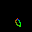

[0] expected, [1] found with score [0.813836]


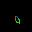

[0] expected, [1] found with score [0.867046]


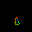

[0] expected, [1] found with score [0.802388]


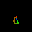

[0] expected, [1] found with score [0.894498]


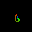

[0] expected, [1] found with score [0.840073]


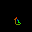

[0] expected, [1] found with score [0.832182]


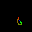

[0] expected, [1] found with score [0.858515]


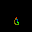

[0] expected, [1] found with score [0.817441]


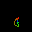

Testing Gesture:  1  with datasize:  319
98.4% correct (N=547, 69 unknown)


In [ ]:
run_tflite_test(model_no_quant_tflite)

Then test the quantized model

Testing Gesture:  0  with datasize:  297
[0] expected, [1] found with score [0.753906]


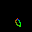

[0] expected, [1] found with score [0.808594]


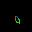

[0] expected, [1] found with score [0.871094]


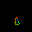

[0] expected, [1] found with score [0.800781]


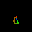

[0] expected, [1] found with score [0.890625]


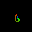

[0] expected, [1] found with score [0.839844]


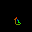

[0] expected, [1] found with score [0.828125]


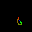

[0] expected, [1] found with score [0.863281]


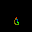

[0] expected, [1] found with score [0.820312]


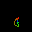

Testing Gesture:  1  with datasize:  319
98.4% correct (N=549, 67 unknown)


In [ ]:
run_tflite_test(model_tflite)

If you'd like to manually evaluate particular images you can uncomment, update, and run the below cell and select an image from the test folder.

In [ ]:
# TEST_IMAGE = # UPDATE ME e.g., "test/0/1.png"
# index, score = predict_tflite(model_no_quant_tflite, TEST_IMAGE)
# print("Float model result:")
# print(index, score) # prints the guessed index and the confidence
# index, score = predict_tflite(model_tflite, TEST_IMAGE)
# print("Quantized model result:")
# print(index, score) # prints the guessed index and the confidence

##2.3 Generate a TensorFlow Lite for Microcontrollers Model
DO NOT MODIFY THE FOLLOWING CELLS

To convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers on Arduino we simply need to use the ```xxd``` tool to convert the ```.tflite``` file into a ```.cc``` file.

In [ ]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}
# Update variable names
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' {TFL_CC_MODEL_FILENAME}

That's it! You've successfully converted your TensorFlow Lite model into a TensorFlow Lite for Microcontrollers model! Run the cell below to print out its contents which we'll need for our next step, deploying the model using the Arudino IDE!

In [ ]:
# Print the C source file
!cat {TFL_CC_MODEL_FILENAME}
# !tail {TFL_CC_MODEL_FILENAME} # run this command to just see the end of the file (aka the size)

Streaming output truncated to the last 5000 lines.
  0xf2, 0xed, 0x27, 0x48, 0x31, 0xf8, 0x16, 0x5a, 0x04, 0x2f, 0xf9, 0xf3,
  0xd5, 0x4a, 0xd4, 0x61, 0xe0, 0x47, 0x00, 0x65, 0x33, 0x19, 0x00, 0x18,
  0x70, 0xf6, 0x66, 0x53, 0xec, 0x3f, 0x24, 0x0b, 0x00, 0x05, 0xd3, 0x48,
  0x34, 0xe1, 0x4a, 0x0f, 0x6f, 0x44, 0xf3, 0x3f, 0x2d, 0x34, 0xdd, 0x5e,
  0x2b, 0xbf, 0xfb, 0x16, 0x16, 0x28, 0xb5, 0x3b, 0xef, 0x58, 0xbf, 0x32,
  0xfe, 0xf8, 0x11, 0xfb, 0x18, 0x3e, 0x58, 0xf5, 0x38, 0x65, 0x58, 0x7f,
  0x2c, 0xd7, 0x48, 0x30, 0xe7, 0x00, 0x2d, 0xd2, 0x2b, 0xea, 0x09, 0xc9,
  0xee, 0x48, 0x48, 0x0d, 0x4a, 0x22, 0xe9, 0xfc, 0xe8, 0x56, 0xb8, 0x23,
  0x13, 0x17, 0x13, 0xee, 0x2e, 0x06, 0x4a, 0x03, 0x19, 0x4c, 0x38, 0xe1,
  0x01, 0x69, 0x05, 0xe9, 0x4c, 0x01, 0xf2, 0x3c, 0x53, 0x2c, 0xf2, 0x26,
  0x22, 0x19, 0x1b, 0x10, 0xd8, 0x10, 0x4f, 0xcf, 0x0e, 0x48, 0xfc, 0x2d,
  0xe8, 0xe7, 0x35, 0xf0, 0xf9, 0xd4, 0x32, 0x04, 0x3c, 0xf6, 0xde, 0x0c,
  0x35, 0x0b, 0xaa, 0xcf, 0x5e, 0x47, 0x38, 0xc9, 0x81, 0xe7,

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,520 (1.07 MB)

 Trainable params: 93,506 (365.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 187,014 (730.53 KB)

To download your model for use at a later date:

1. On the left of the UI click on the folder icon
2. Click on the three dots to the right of the ```.cc``` file you just generated and select "download." The file can be found at ```models/{TFL_CC_MODEL_FILENAME}``` which by default is ```models/magic_wand.cc```

Next we'll deploy that model using Platform IO.

##3.1 Theory and Analysis

Answer each of the following questions with 4+ sentences showing your thought process and understanding of the content covered.


###3.1.1
What are some ways in which you could improve the performance of this model?

Ways I could improve the model include more training data, where I collect more samples gesture. I especially want to focus on the misclassified data, augmenting the dataset to resemble those cases. I could also add more data augmentation when creating my dataset. For my model itself, I could use transfer learning and incoporate more comprehensive models, , as well as add regularization to prevent overfitting. Finally, I could adjust the learning rate and add more epochs.



###3.1.2
How could the capability of this ML model (motion detection) be applied to another application and what parameters would you change in the model and the microcontroller code to enable this use case?

This type of magic wand gesture movement could be used in a variety of scenarios. For example, we could use it to convey the human language for deaf speakers. We could also easily add more gestures, such as swiping left and right, pushing and pulling, etc. for some sort of VR experience. In addition, right now, it only uses one pointer as input. We could allow it to track multipler pointers at a time for complex motions and images.